## Create dummy data and labels

In [1]:
import numpy as np   
import matplotlib.pyplot as plt
import random
from scipy.fft import rfft, rfftfreq, irfft

def generate_sine_wave(frequency, time_points):
    return np.sin((2 * np.pi) * (time_points * frequency + random.random())) 

def generate_frequency_distribution(distribution = "planck", max_freq = 250, freq_sample_rate = 10):
    '''
     Returns the magnitude of frequencies, with a list of frequencies as input.
     The shape of the resulting fourier transform is inspired by the shape of Planck's law.
     1 / (x^2 * (exp(1/x)-1))
    '''
    frequencies = np.linspace(0, max_freq, max_freq * freq_sample_rate, endpoint=False)
    f_temp = np.where(frequencies == 0, 1e-2, frequencies) # divide by zero error if f == 0

    if (distribution == "planck"):
        return frequencies, 1/(f_temp**2 * (np.exp(1/f_temp)-1))
    if (distribution == "constant"):
        return frequencies, np.ones(max_freq * freq_sample_rate)   
    if (distribution == "linear"):
        return frequencies,  np.linspace(0, 1, max_freq * freq_sample_rate, endpoint=False)
    print("Correct distribution not found")
    return frequencies, 1/(f_temp**2 * (np.exp(1/f_temp)-1))

def random_frequency_from_density_distribution(max_freq, freq_distribution):  
    '''
     Returns a random frequency from a cumulative distribution: 
        1. Sum the array cumulatively and scale from 0 to 1
        2. Pick a random number between 0 and 1
        3. Loop through the array until you are >= to a random value

    Args:
     max_freq: float
        The maximum frequency that the function can return.
        
     freq_distribution: 1D numpy array
        The density probability distribution
    '''

    cumulative = np.cumsum(freq_distribution)
    cumulative /= cumulative[-1]      
    random_value = random.random()
    frequencies = np.linspace(0, max_freq, len(freq_distribution) , endpoint=False)
    for i, cum_value in enumerate(cumulative):
        if(cum_value >= random_value):
            return frequencies[i]
    return frequencies[i]

def generate_epoch(freq_distribution, N_combined_freq = 100, max_freq = 200, duration = 2, sample_rate = 512):
    '''
     Returns a single epoch.

    Args: TODO

    '''

    N_time_points = sample_rate * duration

    # Create epoch by summing up sines of different frequencies
    epoch = np.zeros(N_time_points)
    time_points = np.linspace(0, duration, N_time_points, endpoint=False)
    for i in range(N_combined_freq):
        freq = random_frequency_from_density_distribution(max_freq, freq_distribution)
        epoch += generate_sine_wave(freq, time_points)
    
    return epoch

def show_plot(x, y, title = "", xlabel = "", ylabel = "", show = True):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if show:
        plt.plot(x, y)
        plt.show()

#### Data Variables:

In [2]:
duration = 2                                # Total duration signal (seconds)
sample_rate = 512                           # Data points per second (Hertz)
N_time_points = sample_rate * duration      # Total number of data points
time_points = np.linspace(0, duration, N_time_points, endpoint=False)

N_combined_freq = 100                       # Number of frequencies to form signal
max_freq = 200                              # Maximum frequency of signal
freq_sample_rate = 10                       # Resolution of frequency
N_freq_points = max_freq * freq_sample_rate
frequencies, freq_distribution = generate_frequency_distribution("planck", max_freq, freq_sample_rate)

#### Create a Dummy signal

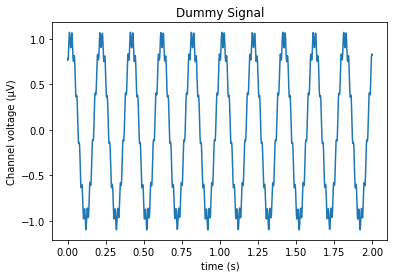

In [3]:
signal = generate_sine_wave(5, time_points)
noise = generate_sine_wave(60, time_points) * 0.1
# noise += generate_sine_wave(6000, time_points) * 0.01
# noise += generate_sine_wave(9000, time_points) 

wave = signal + noise
show_plot(time_points, wave, "Dummy Signal", "time (s)", "Channel voltage (\u03BCV)")

#### Get a Frequency Probability Distribution from the Fourier Transform

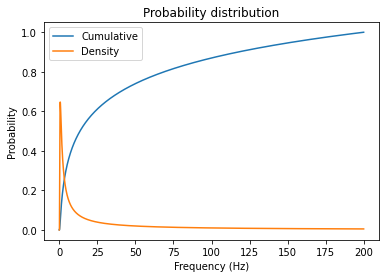

In [4]:
cumulative = np.cumsum(freq_distribution)
cumulative /= cumulative[-1]

show_plot(None, None, "Probability distribution", "Frequency (Hz)", "Probability", show = False)
plt.plot(frequencies, cumulative, label = "Cumulative")
plt.plot(frequencies, freq_distribution/cumulative[-1], label = "Density")
plt.legend()
plt.show()    

#### Get random frequencies from density distribution 

In [5]:
print("Random Frequencies from Distribution:")
for i in range(5):
    print(f'{random_frequency_from_density_distribution(max_freq, freq_distribution):.3f}')

Random Frequencies from Distribution:
39.100
7.400
0.500
6.900
10.800


#### Create signals from random frequencies

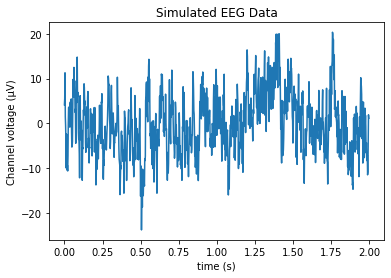

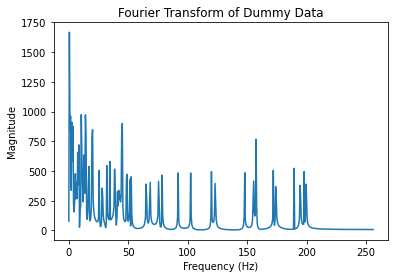

In [6]:
epoch = generate_epoch(freq_distribution, N_combined_freq, max_freq, duration, sample_rate)
show_plot(time_points, epoch, "Simulated EEG Data", "time (s)", "Channel voltage (\u03BCV)")

#### Fourier Transform of Dummy Signal
epoch_FT = rfft(epoch)
freq = rfftfreq(duration * sample_rate, 1 / sample_rate)
show_plot(freq, np.abs(epoch_FT), "Fourier Transform of Dummy Data", "Frequency (Hz)", "Magnitude")

#### Generating Data
+ Put signals into array with dimensions (subjects, channels, epochs) with different signals between subjects


In [19]:
N_subjects_1 = 5
frequencies, planck_distribution = generate_frequency_distribution("planck", max_freq, freq_sample_rate)

N_subjects_2 = 5
frequencies, const_distribution = generate_frequency_distribution("constant", max_freq, freq_sample_rate)

N_channels = 32
N_epochs = 5

subjects_1 = []
subjects_2 = []
channels = []
epochs = []

for i in range(N_subjects_1):
    for j in range(N_channels):
        for k in range(N_epochs):
            epochs.append(generate_epoch(planck_distribution, N_combined_freq, max_freq, duration, sample_rate))
        channels.append(epochs)
        epochs = []
    subjects_1.append(channels)
    channels = []

for i in range(N_subjects_2):
    for j in range(N_channels):
        for k in range(N_epochs):
            epochs.append(generate_epoch(const_distribution, N_combined_freq, max_freq, duration, sample_rate))
        channels.append(epochs)
        epochs = []
    subjects_2.append(channels)
    channels = []

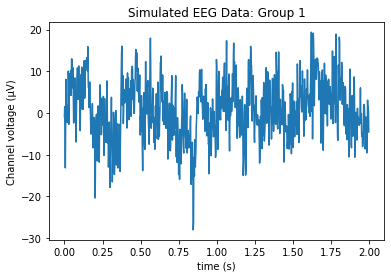

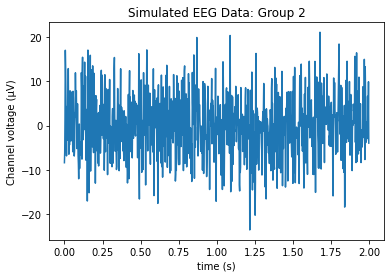

In [22]:
subject_index = 3
channel_index = 1
epoch_index = 1

time_points = np.linspace(0, duration, N_time_points, endpoint=False)
show_plot(time_points, subjects_1[subject_index][channel_index][epoch_index], "Simulated EEG Data: Group 1", "time (s)", "Channel voltage (\u03BCV)")
show_plot(time_points, subjects_2[subject_index][channel_index][epoch_index], "Simulated EEG Data: Group 2", "time (s)", "Channel voltage (\u03BCV)")

#### TODO

+ Add labels to subjects (different labels for different frequency distributions)
+ Save data to file
+ Train on data